In [2]:
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
import numpy as np
import holidays

import matplotlib.pyplot as plt

import sys
sys.path.append("../")
import asset.MyPlot as mp
import asset.DataSupply as ds

import warnings
warnings.filterwarnings("ignore")

In [4]:
# df_rain_historical, dct_areas = ds.GetRainfallByPumps(
#     ["bokhoven"]
# )

# df_dry = GenerateMLdata(
#     "bokhoven",
#     4.348602514328682,
#     -0.6,
#     df_rain_historical,
#     dct_areas
# )

df_dry = pd.read_csv("../asset/data/model_data_bokhoven.csv", index_col=0, parse_dates=True)

In [6]:
df_dry

,bokhoven_in_flow_vol,bokhoven_flow_value,bokhoven_level_value,bokhoven_last_in_flow_vol,bokhoven_vol_remain
end_hour,,,,,
2019-09-01 19:00:00,1.493020,0.000000,0.260000,NaN,3.739798
2019-09-01 20:00:00,1.466006,3.000000,-0.120000,1.493020,2.087329
2019-09-01 21:00:00,2.362741,0.000000,0.423333,1.466006,4.450070
2019-09-03 03:00:00,0.556438,3.333333,-0.177358,2.362741,1.837900
2019-09-03 04:00:00,0.311552,0.000000,-0.105714,0.556438,2.149452
...,...,...,...,...,...
2020-07-31 19:00:00,1.112517,0.000000,0.112500,1.447722,3.098379
2020-07-31 20:00:00,1.907345,3.833333,-0.183333,1.112517,1.811918
2020-07-31 21:00:00,1.275590,0.000000,0.110000,1.907345,3.087508


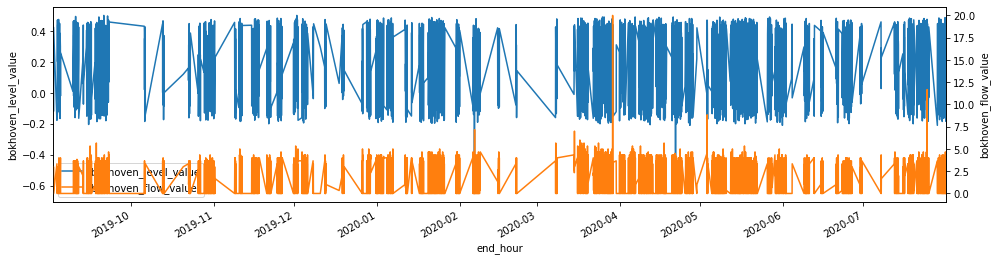

In [8]:
mp.PlotMulti(df_dry[["bokhoven_level_value", "bokhoven_flow_value"]], figsize=(16, 4))

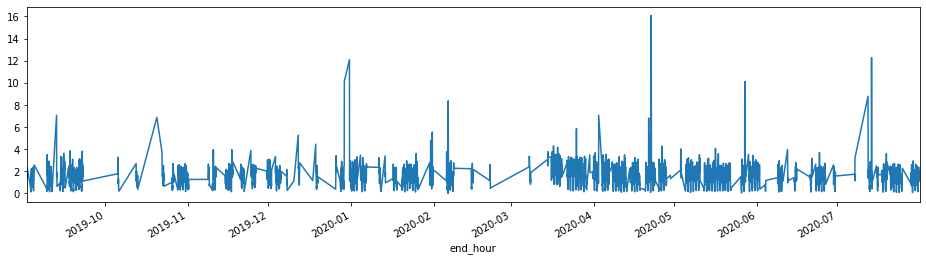

In [11]:
df_grouped = df_dry.groupby("end_hour", as_index=True).sum()[["bokhoven_in_flow_vol", "bokhoven_flow_value"]]
df_grouped["bokhoven_in_flow_vol"].plot(figsize=(16, 4))

In [12]:
nl_holidays = holidays.NL()

df_grouped["hour"] = df_grouped.index.hour
df_grouped["day"] = df_grouped.index.day
df_grouped["weekday"] = df_grouped.index.weekday
df_grouped["month"] = df_grouped.index.month
df_grouped["year"] = df_grouped.index.year
df_grouped["is_holiday"] = [int(i.date() in nl_holidays) for i in df_grouped.index]
df_grouped["bokhoven_last_in_flow_vol"] = df_grouped["bokhoven_in_flow_vol"].shift()
df_grouped["covid"] = df_grouped.index > "2020-03-15 00:00:00"

In [13]:
df_grouped.head(3)

,bokhoven_in_flow_vol,bokhoven_flow_value,hour,day,weekday,month,year,is_holiday,bokhoven_last_in_flow_vol,covid
end_hour,,,,,,,,,,
2019-09-01 19:00:00,1.493020,0.0,19,1,6,9,2019,0,NaN,False
2019-09-01 20:00:00,1.466006,3.0,20,1,6,9,2019,0,1.493020,False
2019-09-01 21:00:00,2.362741,0.0,21,1,6,9,2019,0,1.466006,False


In [14]:
# estimators
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import xgboost as xgb
from sklearn.linear_model import ElasticNet

# evaluators
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [15]:
seed = 666

data = df_grouped.copy()
X = data.iloc[1:, 2:]
y = data.iloc[1:, 0]

best_sfs = None
best_nmae = float("-inf")
for i in range(1, 8):
    sfs_temp = SFS(
        RandomForestRegressor(random_state=seed),
        k_features=i,
        forward=True,
        floating=False,
        scoring="neg_mean_absolute_error",
        cv=0,
    )
    sfs_temp.fit(X, y)
    print(f"""{i} features, with neg_mean_absolute_error: {sfs_temp.k_score_}""")
    if sfs_temp.k_score_ > best_nmae:
        best_sfs = sfs_temp
        best_nmae = sfs_temp.k_score_


print(f"best: {best_sfs.k_feature_names_}")
X_new = best_sfs.transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.2, random_state=seed
)

1 features, with neg_mean_absolute_error: -0.27783708358745585
2 features, with neg_mean_absolute_error: -0.18769499292333763
3 features, with neg_mean_absolute_error: -0.17578896265229224
4 features, with neg_mean_absolute_error: -0.1680973601539153
5 features, with neg_mean_absolute_error: -0.16596043014689438
6 features, with neg_mean_absolute_error: -0.16649299716932367
7 features, with neg_mean_absolute_error: -0.16587790001719538
best: ('hour', 'weekday', 'month', 'year', 'is_holiday', 'bokhoven_last_in_flow_vol', 'covid')


In [16]:
# params for rf
min_samples_split = [
    10, 20,30
]
min_samples_leaf = [
    1, 2, 4, 6
]

# params for xgb
subsample = [
    0.5, 0.8, 1
]
objective = ["reg:squarederror", "reg:pseudohubererror"]
gamma = [
    0,1,5
]

# params for en
max_iter = [1, 5, 10]
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
l1_ratio = np.arange(0.0, 1.0, 0.1)

# params for rf & xgb
n_estimators = [int(x) for x in np.linspace(start=50, stop=150, num=5)]
max_depth = [int(x) for x in np.linspace(5, 25, num=5)]
max_depth.append(None)


names = [
    "RandomForestRegressor",
    "XGBRegressor",
    "ElasticNet",
]

estimators = [RandomForestRegressor(), xgb.XGBRegressor(), ElasticNet()]

param_rfr = {
    "bootstrap": [True],
    "max_features": ["auto"],
    "random_state": [seed],
    "n_estimators": n_estimators,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
}

param_xgbr = {
    "eval_metric": ["mae"],
    "booster": ["gbtree"],
    "learning_rate": [0.1],
    "min_child_weight": [1],
    "gamma": gamma,
    "nthread": [4],
    "scale_pos_weight": [1],
    "colsample_bytree": [0.3],
    "n_estimators": n_estimators,
    "max_depth": max_depth,
    "subsample": subsample,
    "objective": objective,
}

param_en = {"max_iter": max_iter, "alpha": alpha, "l1_ratio": l1_ratio}

parameters = [param_rfr, param_xgbr, param_en]

In [17]:
def gird_search_model(reg, param, name, X_train, y_train, X_test, y_test):
    model = GridSearchCV(
        reg,
        param,
        cv=3,
        verbose=2,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        return_train_score=True,
    )
    fit = model.fit(X_train, y_train)
    y_test_pred = fit.best_estimator_.predict(X_test)
    mae = mean_absolute_error(y_test_pred, y_test)

    cv_results = pd.DataFrame(fit.cv_results_).set_index(["params"])

    print("MODEL : %r" % name)
    print("Best MAE: %f using %s" % (mae, fit.best_params_))

    return cv_results, mae, fit

In [18]:
best_estimators = dict()
score = []
cv_list = []
for clf, param, name in zip(estimators, parameters, names):

    (cv_result, mae, fit) = gird_search_model(
        clf, param, name, X_train, y_train, X_test, y_test
    )
    cv_list.append(cv_result)
    best_estimators[name] = fit
    score.append(mae)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  1.2min finished


MODEL : 'RandomForestRegressor'
Best MAE: 0.370620 using {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 20, 'n_estimators': 125, 'random_state': 666}
Fitting 3 folds for each of 540 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 684 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 1250 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  1.3min finished


MODEL : 'XGBRegressor'
Best MAE: 0.349352 using {'booster': 'gbtree', 'colsample_bytree': 0.3, 'eval_metric': 'mae', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'nthread': 4, 'objective': 'reg:pseudohubererror', 'scale_pos_weight': 1, 'subsample': 1}
Fitting 3 folds for each of 210 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:    0.6s finished


MODEL : 'ElasticNet'
Best MAE: 0.506011 using {'alpha': 0.01, 'l1_ratio': 0.9, 'max_iter': 5}


In [19]:
theBest = best_estimators["RandomForestRegressor"].best_estimator_

In [20]:
y_predicted = theBest.predict(X_new)

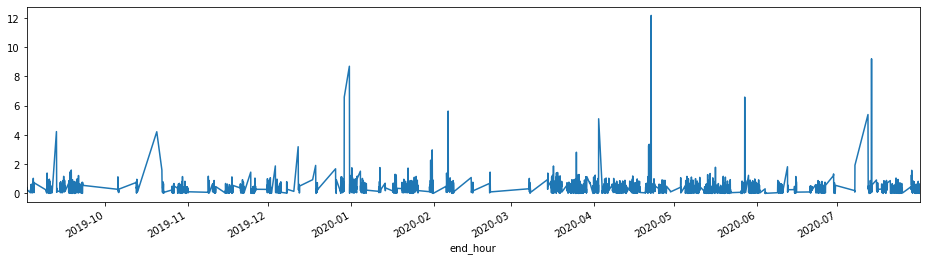

In [21]:
abs(y_predicted - y).plot(figsize=(16, 4))

In [22]:
mean_absolute_error(y_predicted, y)

0.351425173811185

In [23]:
y.describe()

count    3168.000000
mean        1.515912
std         0.967825
min         0.000000
25%         0.858590
50%         1.467444
75%         2.053427
max        16.090758
Name: bokhoven_in_flow_vol, dtype: float64

In [24]:
ddd = y.to_frame()
ddd["predicted"] = y_predicted


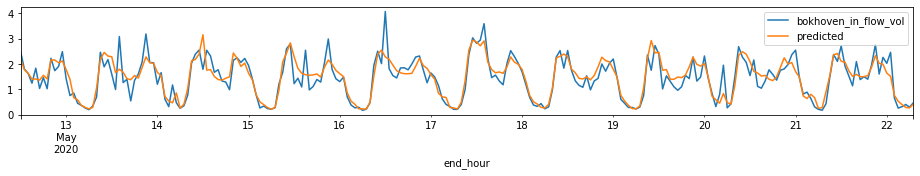

In [25]:
ddd["2020-05-12 12:00:00":"2020-05-23 12:00:00"].plot(figsize=(16, 2))

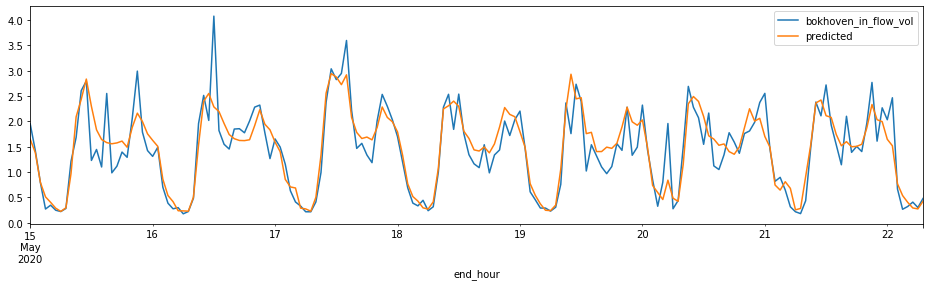

In [26]:
ddd["2020-05-15 00:00:00":"2020-05-25 00:00:00"].plot(figsize=(16, 4))

In [28]:
np.sum(df_dry["bokhoven_in_flow_vol"]), np.sum(df_dry["bokhoven_flow_value"])

(4803.901354835954, 5403.833333333333)

### hypothesis check if Covid-19 lock down is significant feature

t= -0.5236930119777824 p_two= 0.6030908106184663 df= 44.49635599819955
accept H_0，no statistical significance
H_0：Two samples have no difference


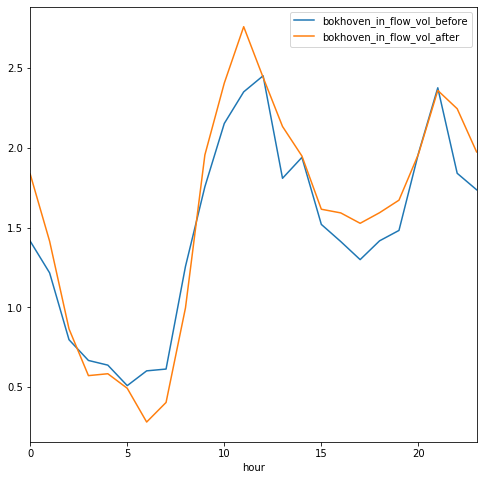

In [30]:
import statsmodels.stats.weightstats as st

test_item = "bokhoven_in_flow_vol"

df_b = df_grouped[:"2020-03-01 00:00:00"][[test_item, "hour"]]
df_a = df_grouped["2020-03-01 00:00:00":][[test_item, "hour"]]
ss = (
    df_b.groupby(["hour"])
    .mean()
    .join(df_a.groupby(["hour"]).mean(), lsuffix="_before", rsuffix="_after")
)
ss.plot(figsize=(8, 8))

t, p_two, df = st.ttest_ind(
    ss[f"{test_item}_before"], ss[f"{test_item}_after"], usevar="unequal"
)
print("t=", t, "p_two=", p_two, "df=", df)

alpha = 0.05
if p_two < alpha / 2:
    print("refuse H_0，statistical significance, accept H_a")
    print("H_a：Two samples have difference")
else:
    print("accept H_0，no statistical significance")
    print("H_0：Two samples have no difference")

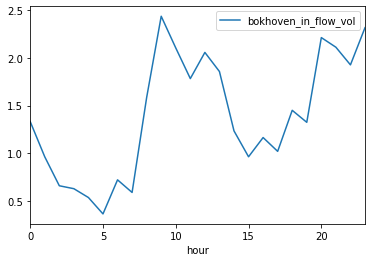

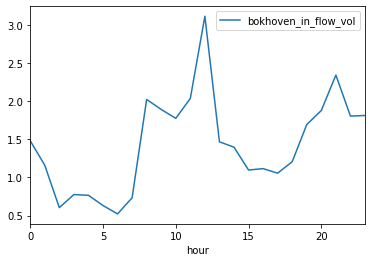

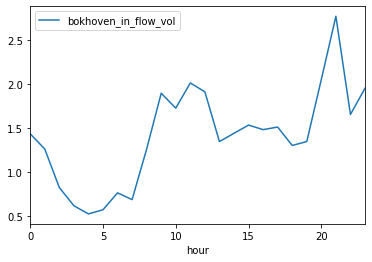

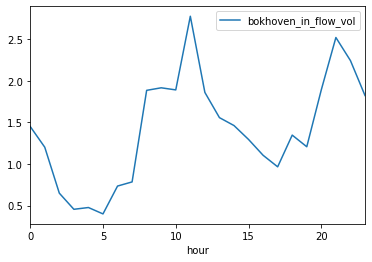

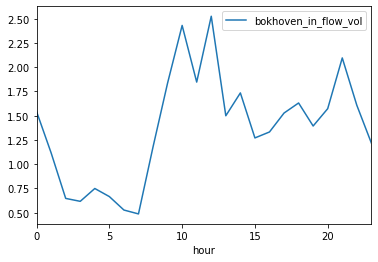

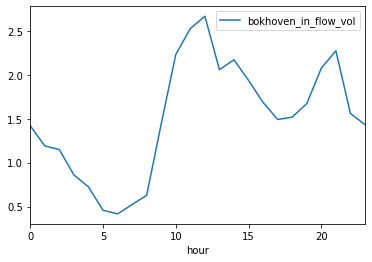

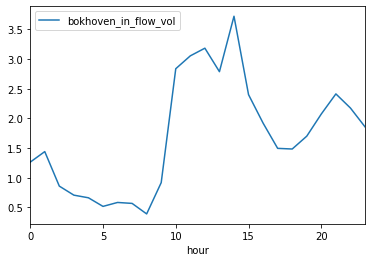

In [31]:
df = df_grouped[:"2020-03-01 00:00:00"][["bokhoven_in_flow_vol", "hour", "weekday"]].copy()
ss = df.groupby(["weekday", "hour"]).mean()
for i in range(7):
    ss.loc[i].plot()

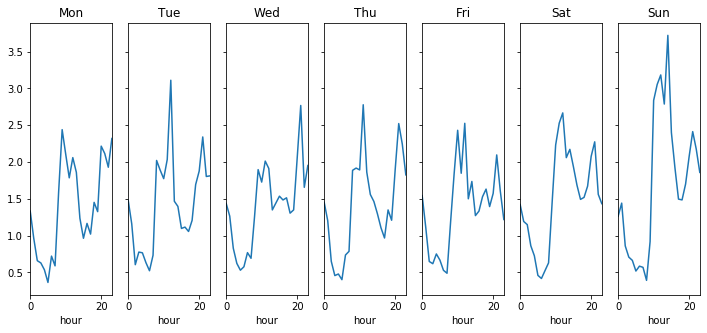

In [32]:
fig, ((ax0, ax1, ax2, ax3, ax4, ax5, ax6)) = plt.subplots(
    nrows=1, ncols=7, sharey=True, figsize=(12, 5)
)

ss.loc[0].plot(ax=ax0).set_title("Mon")
ss.loc[1].plot(ax=ax1).set_title("Tue")
ss.loc[2].plot(ax=ax2).set_title("Wed")
ss.loc[3].plot(ax=ax3).set_title("Thu")
ss.loc[4].plot(ax=ax4).set_title("Fri")
ss.loc[5].plot(ax=ax5).set_title("Sat")
ss.loc[6].plot(ax=ax6).set_title("Sun")
ax0.get_legend().remove()
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()
ax5.get_legend().remove()
ax6.get_legend().remove()